# Spectra Merge Algorithm

OpenMS provides spectra merging and averaging algorithms in
[SpectraMerger](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.SpectraMerger.html)
class. Spectra merging is to merge multiple related spectra into a
single one - thus, often we end up with a reduced number of spectra. For
instance, MS1 spectra within a pre-defined retention time window or MS2
spectra from the same precursor ion. On the other hand, spectra
averaging incorporates the signal from neighbouring spectra for each
spectrum. Thus, the number of spectra remains the same after spectra
averaging. Both merging and averaging attempt to increase the quality of
spectrum by increasing its signal to noise ratio.

Spectra merging and averaging are implemented in SpectraMerger in
pyOpenMS, which provides two merging (block wise and precursor method -
see below) and two averaging methods (gaussian and tophat - see below).
For merging, we can use

-   mergeSpectraBlockWise
-   mergeSpectraPrecursors

and for averaging, we use

-   average

with two different options: gaussian and tophat methods.
[SpectraMerger](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.SpectraMerger.html)
inherits
[DefaultParamHandler](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.DefaultParamHandler.html).
Thus you could list the full set of parameters as described in
[Parameter handling](parameter_handling.ipynb).

## Loading the Raw Data

Let's take a look at the different algorithms in the examples below.
First we download a test MS/MS dataset.

In [ ]:
# retrieve data
from urllib.request import urlretrieve
import pyopenms as oms
import matplotlib.pyplot as plt

gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(gh + "/src/data/small.mzML", "test.mzML")

# load MS data and store as MSExperiment object
exp = oms.MSExperiment()
oms.MzMLFile().load("test.mzML", exp)

## Block wise spectra merging

Our first example merges MS1 spectra block wise.

In [ ]:
spectra = exp.getSpectra()

# Collecting only MS1 spectra
spectra_ms1 = [s for s in spectra if s.getMSLevel() == 1]
print(f"Number of MS1 spectra before merge are {len(spectra_ms1)}")

# merges blocks of MS1
merger = oms.SpectraMerger()
merger.mergeSpectraBlockWise(exp)

# Get spectra from the updated (merged) experiment
spectraMerged = exp.getSpectra()
spectraMerged_ms1 = [s for s in spectraMerged if s.getMSLevel() == 1]
print(f"Number of MS1 spectra after merge are {len(spectraMerged_ms1)}")
# store merged spectra in the disk
oms.MzMLFile().store("blockwiseMerged.mzML", exp)

# Setting up subplots for five original spectra and merged spectrum
fig, axs = plt.subplots(6)
fig.set_figheight(8)
plt.subplots_adjust(hspace=1)

for i in range(0, 6):
    s = spectra_ms1[i] if i < 5 else spectraMerged_ms1[0]
    axs[i].plot(s.get_peaks()[0], s.get_peaks()[1], linewidth=0.2)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e3, 1e7)
    axs[i].set_xlim(360, 1000)
    axs[i].title.set_text(
        "Input MS1 spectrum " + str(i + 1) if i < 5 else "Merged MS1 spectrum"
    )
plt.show()

``` output
Number of MS1 spectra before merge are 183
Number of MS1 spectra after merge are 37
Cluster sizes:
  size 3: 1x
  size 5: 36x
Number of merged peaks: 87177/360394 (24.19 %) of blocked spectra
```

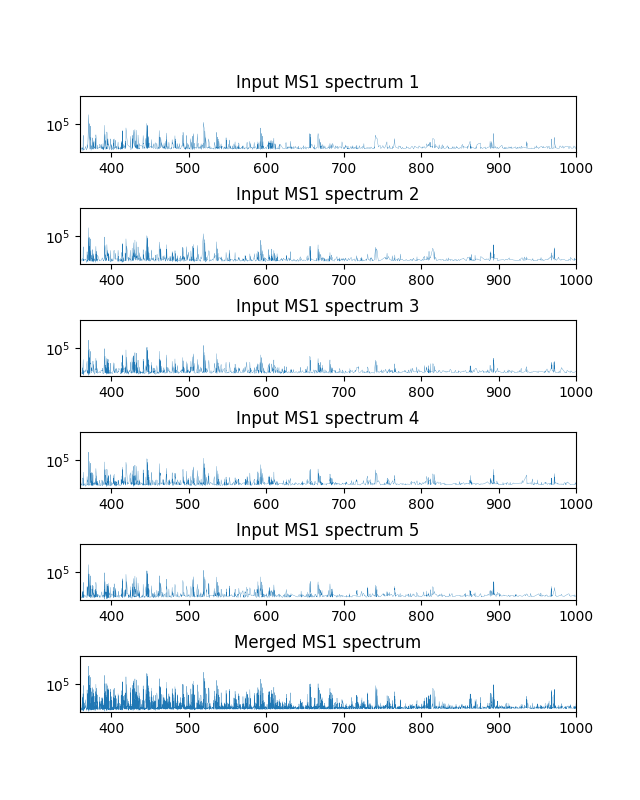

Above example clearly demonstrates the benefit of spectra merging. The
upper rows show the input spectra and the bottom the merged one. The
merged spectrum (bottom) has far more signal peaks of higher intensities
than the input spectra.

By default, the method `mergeSpectraBlockWise` of
[SpectraMerger](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.SpectraMerger.html)
merges 5 consecutive MS1 spectra into a block. The block size could be
adjusted by using `block_method:rt_block_size` parameter as follows:

In [ ]:
# again load MS data and store as MSExperiment object
exp = oms.MSExperiment()
oms.MzMLFile().load("test.mzML", exp)

# again load MS data and store as MSExperiment object
exp = oms.MSExperiment()
oms.MzMLFile().load("test.mzML", exp)

# adjust block size to 10 spectra and merge
merger = oms.SpectraMerger()
param = merger.getParameters()
param.setValue("block_method:rt_block_size", 10)
merger.setParameters(param)
merger.mergeSpectraBlockWise(exp)

spectraMerged = exp.getSpectra()
spectraMerged_ms1_10scans = [s for s in spectraMerged if s.getMSLevel() == 1]

# store merged spectra in the disk
oms.MzMLFile().store("blockwiseMerged_10scans.mzML", exp)

fig, axs = plt.subplots(2)
fig.set_figheight(4)
plt.subplots_adjust(hspace=1)

for i in range(0, 2):
    s = spectraMerged_ms1_10scans[0] if i == 0 else spectraMerged_ms1[0]
    axs[i].plot(s.get_peaks()[0], s.get_peaks()[1], linewidth=0.2)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e3, 1e7)
    axs[i].set_xlim(360, 1000)
    axs[i].title.set_text(
        "Merged MS1 spectrum with 10 scans"
        if i == 0
        else "Merged MS1 spectrum with 5 scans"
    )
plt.show()

``` output
Number of MS1 spectra after merge are 19
Cluster sizes:
  size 3: 1x
  size 10: 18x
Number of merged peaks: 117793/360394 (32.68 %) of blocked spectra
72 spectra and 1 chromatograms stored.
```

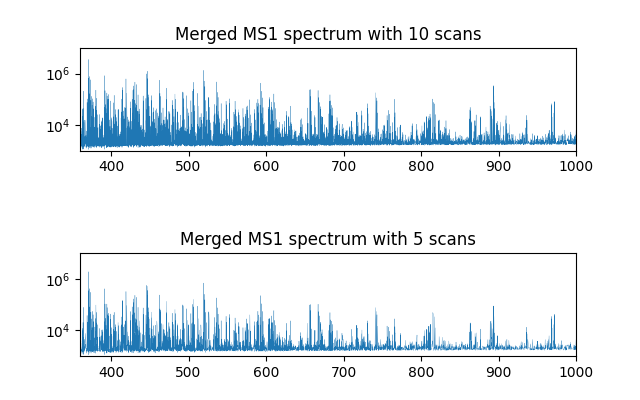

As shown in the above figure, clearer signal peaks are obtained with 10
MS1 scans being merged, compared to 5 MS1 scans we used before. Note
that the y-axis is in log scale. But if too many scans are merged,
spectra containing too different sets of molecules would be merged,
yielding a poor quality spectrum. The users may want to try a few
different parameters to produce spectra of optimal quality.

## MS2 spectra merging with precursor method

Next we perform MS2 spectra merging with precursor method by using the
`mergeSpectraPrecursors` method. With this method, the MS2 spectra from
the same precursor m/z (subject to tolerance) are merged.

In [ ]:
# load MS data and store as MSExperiment object
exp = oms.MSExperiment()
oms.MzMLFile().load("test.mzML", exp)

spectra = exp.getSpectra()

# spectra with ms_level = 2
spectra_ms2 = [s for s in spectra if s.getMSLevel() == 2]
print(f"Number of MS2 spectra before merge are {len(spectra_ms2)}")

# merge spectra with similar precursors
merger = oms.SpectraMerger()
merger.mergeSpectraPrecursors(exp)

spectraMerged = exp.getSpectra()
spectraMerged_ms2 = [s for s in spectraMerged if s.getMSLevel() == 2]
print(f"Number of MS2 spectra after merge are {len(spectraMerged_ms2)}")

``` output
Number of MS2 spectra before merge are 53
Number of MS2 spectra after merge are 53
Cluster sizes:
Number of merged peaks: 0/0 (nan %) of blocked spectra
```

In the above example, no MS2 spectra have been merged because no MS2
spectra had the same precursor m/z values (subject to tolerance) within
retention time window. By default, the retention time window size is 5.0
seconds and the precursor m/z tolerance is 1e-4Th. If you open the
test.mzML file, you can see a few MS2 spectra (e.g., scan numbers 2077
and 2099) have quite close precursor m/z values (both have precursor m/z
of 432.902Th), but they are apart from each other by about 10 seconds.
We adjust both m/z tolerance and retention time such that MS2 spectra
are merged together with `precursor_method:mz_tolerance` and
`precursor_method:rt_tolerance` parameters.

In [ ]:
# adjust mz and rt tolerances for MS2 spectra grouping for merging
param = merger.getParameters()
param.setValue("precursor_method:rt_tolerance", 10.0)
param.setValue("precursor_method:mz_tolerance", 1e-3)
merger.setParameters(param)
merger.mergeSpectraPrecursors(exp)

# now rerun precursor method merging of MS2 spectra
spectraMerged = exp.getSpectra()
spectraMerged_ms2 = [s for s in spectraMerged if s.getMSLevel() == 2]
print(f"Number of MS2 spectra after merge are {len(spectraMerged_ms2)}")

# store modified data
oms.MzMLFile().store("precursorMethodMerged.mzML", exp)

``` output
Number of MS2 spectra after merge are 45
Cluster sizes:
size 2: 8x
Number of merged peaks: 488/2262 (21.57 %) of blocked spectra
```

To check which MS2 spectra are merged together, one can print out the
native IDs of the spectra. The native ID of each merged spectrum
contains all native IDs of the spectra being merged (comma separated) -
this also holds for block wise merging method.

In [ ]:
# check which input MS2 spectra were merged
merged_spectra = dict()
for index, s in enumerate(spectraMerged_ms2):
    native_IDs = s.getNativeID().split(",")
    if len(native_IDs) > 1:  # spectrum is merged
        print(native_IDs)
        merged_specs = []
        for native_ID in native_IDs:
            for s2 in spectra_ms2:  # original spectra
                if native_ID == s2.getNativeID():
                    merged_specs.append(s2)
                    break
        merged_spectra[index] = merged_specs

``` output
['controllerType=0 controllerNumber=1 scan=1986', 'controllerType=0 controllerNumber=1 scan=2010']
['controllerType=0 controllerNumber=1 scan=1991', 'controllerType=0 controllerNumber=1 scan=2015']
['controllerType=0 controllerNumber=1 scan=1992', 'controllerType=0 controllerNumber=1 scan=2014']
['controllerType=0 controllerNumber=1 scan=2026', 'controllerType=0 controllerNumber=1 scan=2050']
['controllerType=0 controllerNumber=1 scan=2037', 'controllerType=0 controllerNumber=1 scan=2059']
['controllerType=0 controllerNumber=1 scan=2062', 'controllerType=0 controllerNumber=1 scan=2088']
['controllerType=0 controllerNumber=1 scan=2077', 'controllerType=0 controllerNumber=1 scan=2099']
['controllerType=0 controllerNumber=1 scan=2084', 'controllerType=0 controllerNumber=1 scan=2107']
```

We can confirm that scans 2077 and 2099 have been merged. In addition,
we had a few more pairs of MS2 spectra that were merged. We also plot
the input and merged spectra below.

In [ ]:
# plot the merged and merging MS2 spectra

fig, axs = plt.subplots(3, min(4, len(merged_spectra)))
fig.set_figheight(7)
fig.set_figwidth(14)
plt.subplots_adjust(hspace=1)

for index, item in enumerate(merged_spectra.items()):
    if index == 4:  # show 4 examples
        break
    specs = item[1]
    for i in range(0, 3):
        s = specs[i] if i < 2 else spectraMerged_ms2[item[0]]
        axs[i, index].bar(s.get_peaks()[0], s.get_peaks()[1], width=1)
        axs[i, index].set_yscale("log")
        axs[i, index].set_ylim(1e3, 1e5)
        axs[i, index].set_xlim(0, 1200)
        axs[i, index].title.set_text(
            "Input MS2 spectrum" if i < 2 else "Merged MS2 spectrum"
        )
plt.show()

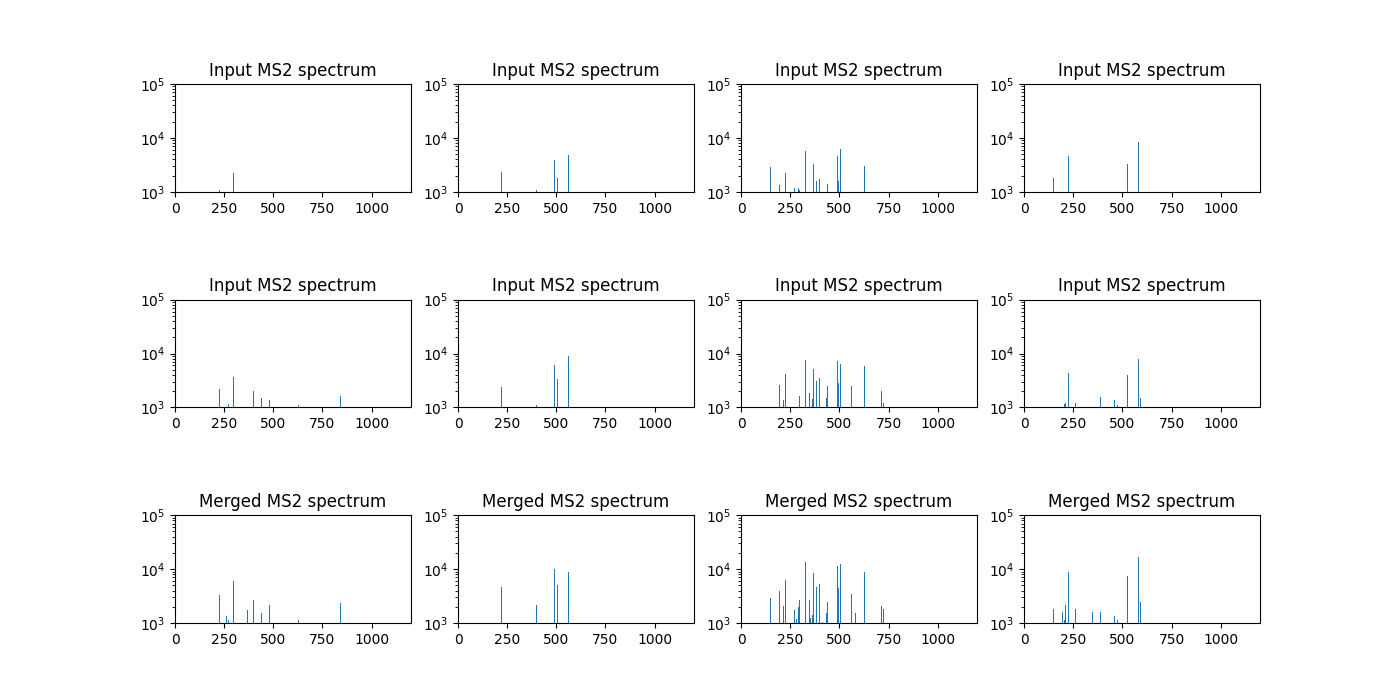

Four examples of MS2 spectra before and after merging are provided
above. Each column shows an example. The upper rows show the input
spectra and the bottom the merged one. The input MS2 spectra selected by
the precursor method show quite similar peak distributions, indicating
they are indeed from the same molecule ions. Moreover, as in the above
block wise merging, we can check that a merged MS2 spectrum has more
peaks than input spectra, possibly containing more complete
fragmentation ion masses.

## Spectra averaging : gaussian and top hat methods

[SpectraMerger](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.SpectraMerger.html)
offers the method `average` to average peak intensities over
neighbouring spectra for a given spectrum. As mentioned above, in
contrast to spectra merging, the number of spectra after averaging does
not change since it is carried out for each individual input spectrum.
The two averaging methods (`gaussian` or `tophat`) determine how
neighbouring spectra are collected and how weights for the averaging are
determined. The `gaussian` method performs weighted average over the
neighbouring spectra with weights having the shape of gaussian shape
(i.e., sharply decreasing from the center). On the other hand, the
`tophat` method, as the name implies, performs a simple averaging over
the neighbouring spectra (all weights are identical). Below, we perform
`gaussian` averaging method.

In [ ]:
# load MS data and store as MSExperiment object
exp = oms.MSExperiment()
oms.MzMLFile().load("test.mzML", exp)
spectra = exp.getSpectra()

# number of MS1 spectra before averaging
spectra_ms1 = [s for s in spectra if s.getMSLevel() == 1]
print(f"Number of MS1 spectra before averaging are {len(spectra_ms1)}")

# average spectra with gaussian
merger = oms.SpectraMerger()
merger.average(exp, "gaussian")
spectraAveraged = exp.getSpectra()

# number of MS1 spectra after averaging
spectraAveraged_ms1 = [s for s in spectraAveraged if s.getMSLevel() == 1]
print(f"Number of MS1 spectra after averaging are {len(spectraAveraged_ms1)}")

fig, axs = plt.subplots(2)
fig.set_figheight(4)
plt.subplots_adjust(hspace=1)

for i in range(0, 2):
    s = spectra_ms1[0] if i == 0 else spectraAveraged_ms1[0]
    axs[i].plot(s.get_peaks()[0], s.get_peaks()[1], linewidth=.2)
    axs[i].set_yscale("log")
    axs[i].set_ylim(5e2, 1e6)
    axs[i].set_xlim(360, 600)
    axs[i].title.set_text("Before averaging" if i == 0 else "After averaging")
plt.show()

# store modified data
oms.MzMLFile().store("averagedData.mzML", exp)

``` output
Number of MS1 spectra before averaging are 183
Number of MS1 spectra after averaging are 183
```

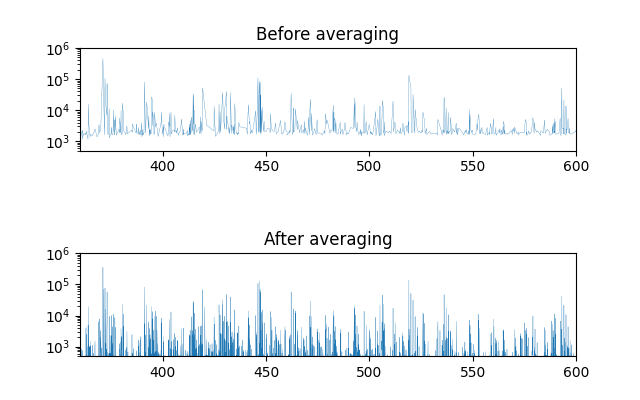

After averaging has been applied, the the number of spectra does not
change as we mentioned above. But the above plots show that the base
line intensity has decreased significantly after averaging. The signal
peaks are better separated in the averaged spectrum than in the original
spectrum as well.